In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

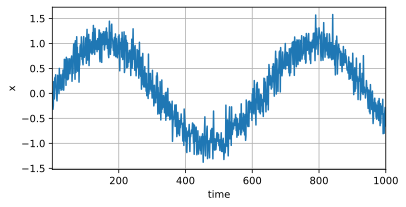

In [2]:
# generate a total of 1000 points
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(.01 * time) + torch.normal(0, .2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [7]:
tau = 4
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels = x[tau:].reshape((-1, 1))

In [8]:
# only the first n_train examples are used for training 
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size=batch_size, is_train=True)

In [13]:
# func for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
# a simple MLP
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net
# square loss
loss = nn.MSELoss()

In [14]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch+1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

In [15]:
net = get_net()
train(net, train_iter, loss, 5, .01)

epoch 1, loss: 0.065019
epoch 2, loss: 0.052037
epoch 3, loss: 0.051462
epoch 4, loss: 0.050831
epoch 5, loss: 0.052244


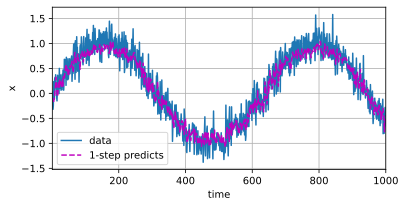

In [16]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()],
         'time', 'x', legend=['data', '1-step predicts'], 
         xlim=[1, 1000], figsize=(6, 3))

In [17]:
onestep_preds.shape

torch.Size([996, 1])

torch.Size([1000])


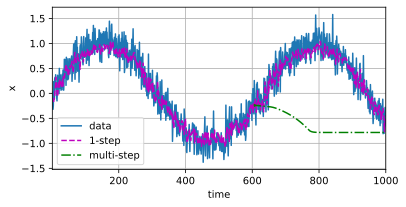

In [22]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]
for i in range(n_train + tau, T):
    # why .reshape(1, -1)?
    multistep_preds[i] = net(multistep_preds[i-tau: i])
print(multistep_preds.shape)
d2l.plot([time, time[tau:], time[n_train+tau:]], 
         [x.detach().numpy(), 
         onestep_preds.detach().numpy(), 
         multistep_preds[n_train+tau:].detach().numpy()], 
         'time', 'x', legend=['data', '1-step', 'multi-step'],
         xlim=[1, 1000], figsize=(6, 3))